## GNN_DTI Based Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil
from IPython.display import clear_output

In [3]:
class Opts: pass

### Options

In [4]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.46108546619827
gnn_opts.initial_dev = 0.19818493842903845
gnn_opts.dropout_rate = 0.2

In [5]:
learn_opts = Opts()
learn_opts.num_epochs = 1000
learn_opts.lr = 0.0001
learn_opts.batch_size = 64

In [6]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
myopts.random_stratify = True
myopts.cache_dir = '/tmp/moldata'
myopts.clear_cache = False
myopts.train_keys = 'keys/keys_refined'
myopts.kinase_list = 'keys/kinase_list'
myopts.dataset_version = 2
myopts.cpu_count = 10

In [7]:
assert myopts.dataset_version in [1, 2]
if myopts.dataset_version == 1:
    import dataset as ds
else:
    import dataset2 as ds

### Support functions for learning loop

In [8]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))

        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [9]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [10]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify)

write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(202, 50, 75)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(202, 50)

In [13]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2

In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

In [15]:
model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()

number of parameters :  215567


### Start Learning

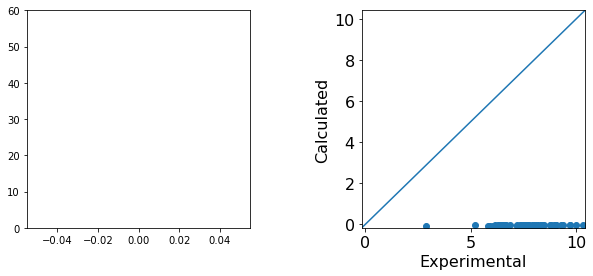

rmse: 7.748, mae: 7.627, r2: 0.333, rho: 0.374
--- Too may off-valued molecules ---

Epoch: 0	Lapse: 4.0s	Losses: (56.693, 60.030)	Best: (56.693, 60.030)


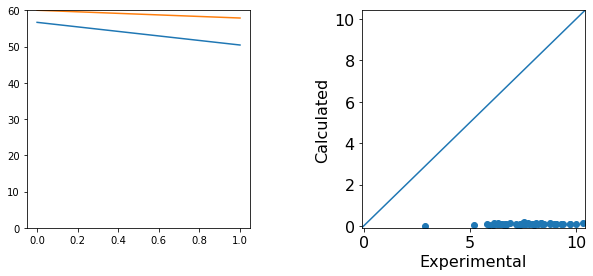

rmse: 7.608, mae: 7.487, r2: 0.407, rho: 0.299
--- Too may off-valued molecules ---

Epoch: 1	Lapse: 5.2s	Losses: (50.438, 57.886)	Best: (50.438, 57.886)


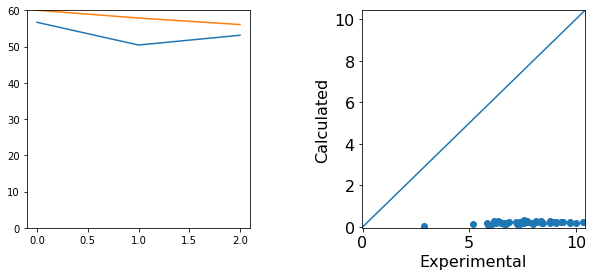

rmse: 7.489, mae: 7.367, r2: 0.411, rho: 0.275
--- Too may off-valued molecules ---

Epoch: 2	Lapse: 4.9s	Losses: (53.127, 56.084)	Best: (50.438, 56.084)


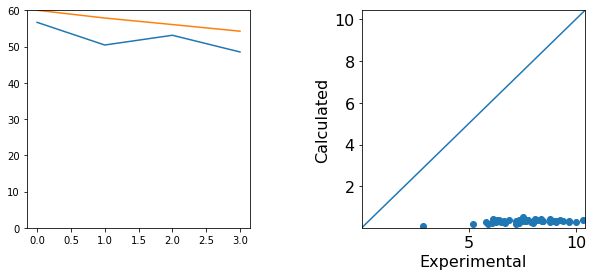

rmse: 7.366, mae: 7.244, r2: 0.417, rho: 0.285
--- Too may off-valued molecules ---

Epoch: 3	Lapse: 5.1s	Losses: (48.517, 54.254)	Best: (48.517, 54.254)


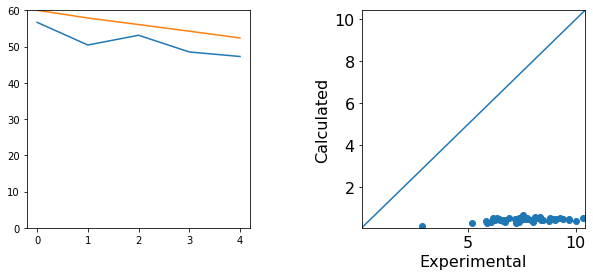

rmse: 7.238, mae: 7.115, r2: 0.428, rho: 0.275
--- Too may off-valued molecules ---

Epoch: 4	Lapse: 5.0s	Losses: (47.270, 52.382)	Best: (47.270, 52.382)


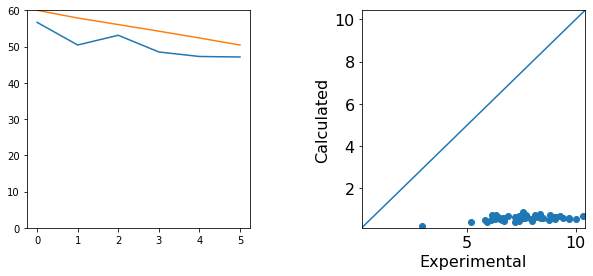

rmse: 7.101, mae: 6.978, r2: 0.421, rho: 0.269
--- Too may off-valued molecules ---

Epoch: 5	Lapse: 4.9s	Losses: (47.133, 50.429)	Best: (47.133, 50.429)


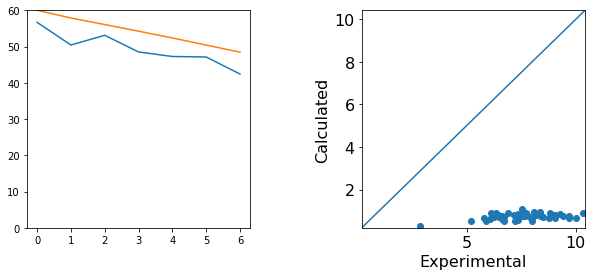

rmse: 6.961, mae: 6.836, r2: 0.414, rho: 0.266
--- Too may off-valued molecules ---

Epoch: 6	Lapse: 5.1s	Losses: (42.426, 48.460)	Best: (42.426, 48.460)


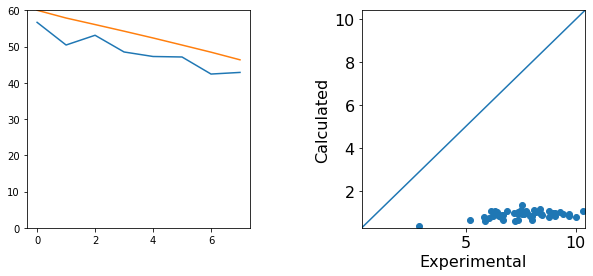

rmse: 6.808, mae: 6.682, r2: 0.407, rho: 0.264
--- Too may off-valued molecules ---

Epoch: 7	Lapse: 5.3s	Losses: (42.876, 46.354)	Best: (42.426, 46.354)


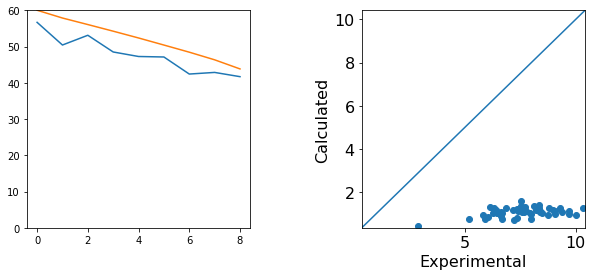

rmse: 6.621, mae: 6.493, r2: 0.401, rho: 0.251
--- Too may off-valued molecules ---

Epoch: 8	Lapse: 5.1s	Losses: (41.704, 43.840)	Best: (41.704, 43.840)


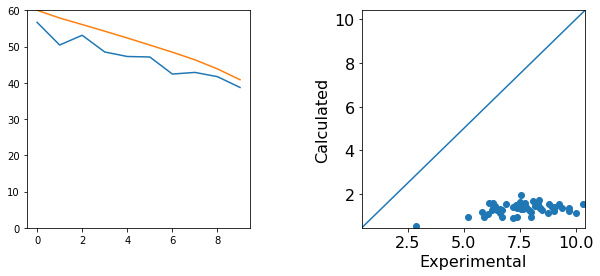

rmse: 6.393, mae: 6.262, r2: 0.398, rho: 0.249
--- Too may off-valued molecules ---

Epoch: 9	Lapse: 5.1s	Losses: (38.727, 40.864)	Best: (38.727, 40.864)


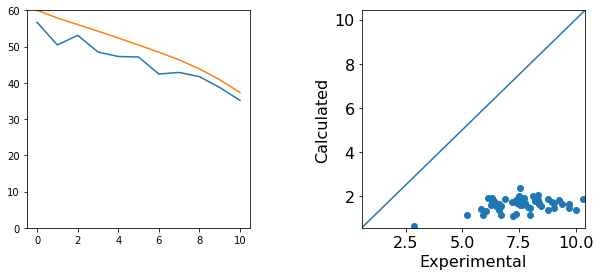

rmse: 6.109, mae: 5.974, r2: 0.392, rho: 0.237
--- Too may off-valued molecules ---

Epoch: 10	Lapse: 5.2s	Losses: (35.162, 37.316)	Best: (35.162, 37.316)


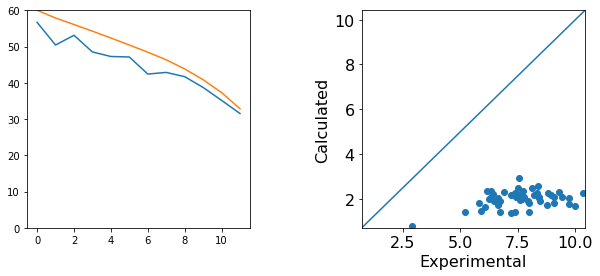

rmse: 5.731, mae: 5.589, r2: 0.383, rho: 0.216
--- Too may off-valued molecules ---

Epoch: 11	Lapse: 5.1s	Losses: (31.539, 32.846)	Best: (31.539, 32.846)


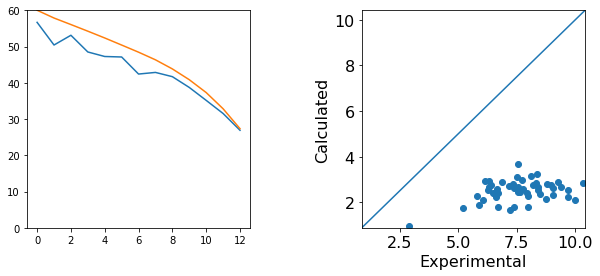

rmse: 5.229, mae: 5.074, r2: 0.375, rho: 0.215
--- Too may off-valued molecules ---

Epoch: 12	Lapse: 5.1s	Losses: (26.909, 27.347)	Best: (26.909, 27.347)


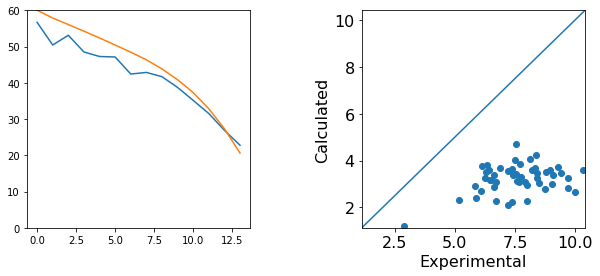

rmse: 4.541, mae: 4.358, r2: 0.366, rho: 0.190
--- Too may off-valued molecules ---

Epoch: 13	Lapse: 5.2s	Losses: (22.783, 20.618)	Best: (22.783, 20.618)


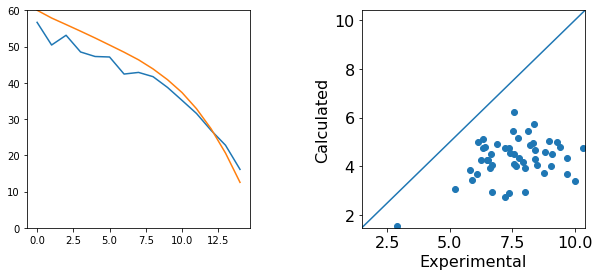

rmse: 3.541, mae: 3.283, r2: 0.351, rho: 0.198
--- Too may off-valued molecules ---

Epoch: 14	Lapse: 5.4s	Losses: (16.122, 12.540)	Best: (16.122, 12.540)


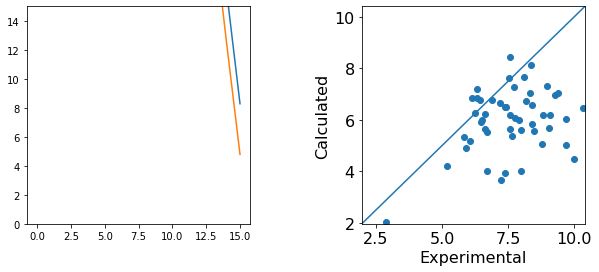

rmse: 2.188, mae: 1.739, r2: 0.332, rho: 0.170
--- Too may off-valued molecules ---

Epoch: 15	Lapse: 5.0s	Losses: (8.283, 4.789)	Best: (8.283, 4.789)


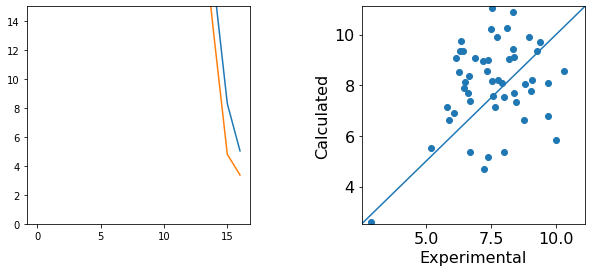

rmse: 1.835, mae: 1.535, r2: 0.320, rho: 0.152


4ivc,10.000,4.149
4fk6,9.700,2.910
4ehz,8.000,2.644
4gfm,7.220,2.508


Epoch: 16	Lapse: 5.4s	Losses: (5.029, 3.367)	Best: (5.029, 3.367)
Epoch: 17	Lapse: 5.1s	Losses: (5.333, 4.357)	Best: (5.029, 3.367)


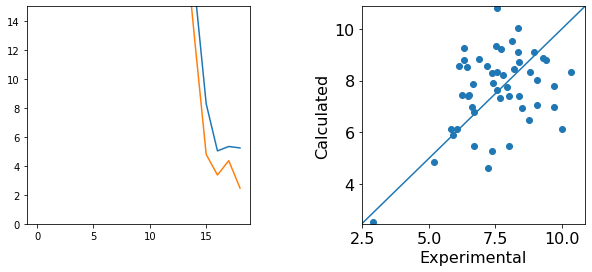

rmse: 1.570, mae: 1.247, r2: 0.412, rho: 0.239


4ivc,10.000,3.884
4fk6,9.700,2.737
4gfm,7.220,2.600
4ehz,8.000,2.520


Epoch: 18	Lapse: 5.5s	Losses: (5.234, 2.465)	Best: (5.029, 2.465)
Epoch: 19	Lapse: 5.4s	Losses: (3.716, 3.535)	Best: (3.716, 2.465)
Epoch: 20	Lapse: 5.3s	Losses: (4.833, 3.246)	Best: (3.716, 2.465)


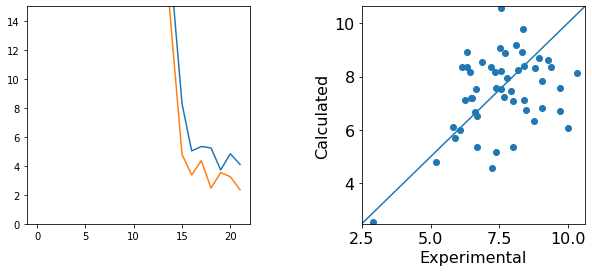

rmse: 1.533, mae: 1.200, r2: 0.417, rho: 0.262


4ivc,10.000,3.916
4fk6,9.700,2.978
4gfm,7.220,2.650
4ehz,8.000,2.633


Epoch: 21	Lapse: 5.8s	Losses: (4.097, 2.351)	Best: (3.716, 2.351)
Epoch: 22	Lapse: 5.6s	Losses: (3.976, 3.143)	Best: (3.716, 2.351)
Epoch: 23	Lapse: 5.5s	Losses: (4.348, 2.969)	Best: (3.716, 2.351)
Epoch: 24	Lapse: 5.6s	Losses: (4.066, 2.702)	Best: (3.716, 2.351)
Epoch: 25	Lapse: 5.8s	Losses: (3.893, 2.547)	Best: (3.716, 2.351)
Epoch: 26	Lapse: 5.8s	Losses: (4.067, 2.542)	Best: (3.716, 2.351)
Epoch: 27	Lapse: 5.5s	Losses: (3.560, 2.357)	Best: (3.560, 2.351)
Epoch: 28	Lapse: 5.6s	Losses: (3.756, 2.457)	Best: (3.560, 2.351)
Epoch: 29	Lapse: 5.6s	Losses: (3.738, 2.471)	Best: (3.560, 2.351)


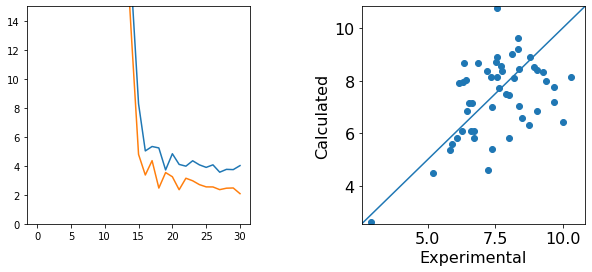

rmse: 1.442, mae: 1.153, r2: 0.500, rho: 0.385


4ivc,10.000,3.572
4gfm,7.220,2.622
4fk6,9.700,2.526


Epoch: 30	Lapse: 6.1s	Losses: (4.014, 2.079)	Best: (3.560, 2.079)
Epoch: 31	Lapse: 5.1s	Losses: (4.175, 2.593)	Best: (3.560, 2.079)
Epoch: 32	Lapse: 5.5s	Losses: (3.836, 2.395)	Best: (3.560, 2.079)


In [ ]:
CLEAR_OUTPUT_WHEN_UPDATE = False
SHOW_VERY_BAD_MOLS = True

best_train_loss, best_val_loss = np.inf, np.inf
Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        write_results_to_csv(L[0], X, y, np.abs(X-y), epoch)

        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))